In [1]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
do_parallel   = False
parallel_nprc = 48   # number of dask workers
parallel_tmem = 200  # max. available RAM

/albedo/home/pscholz/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
if do_parallel:
    from dask.distributed import Client
    # from dask.diagnostics import ProgressBar
    import dask
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client

 --> memory_limit: 4.167 GB


In [3]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/dart_test/'
save_path = None
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'vprofile_clim'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'temp'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
box_regions = list()
box_regions.append('ocean_basins/Arctic_Basin.shp')
box_regions.append('ocean_basins/Eurasian_Basin.shp')
box_regions.append('mpas_region/Canada_Basin.shp')
box_regions.append('mpas_region/North_Atlantic_Ocean.shp')
box_regions.append('mpas_region/Greenland_Sea.shp')
box_regions.append('mpas_region/Irminger_Sea.shp')
box_regions.append('mpas_region/Norwegian_Sea.shp')
box_regions.append('mpas_region/Labrador_Sea.shp')
# box_regions.append('mpas_region/North_Pacific_Ocean.shp')
# box_regions.append('mpas_region/South_Pacific_Ocean.shp')
box_regions.append('mpas_region/Southern_Ocean.shp')
box_regions.append('mpas_region/Western_Weddell_Sea.shp')

#_____________________________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
ncol      = 3 
do_rescale= None
which_dpi = 300

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl != "None"): 
    for ii,ipath in enumerate(input_paths):
        # print(ii, ipath, ipath[0])
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])

#________________________________________________________________________________________________________
# define index regions --> reading shape files
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_regions:
    if region == 'global' or isinstance(region,list): 
        print('global')
        box.append(region)
    else: 
        print(tpv.__path__[0],region)
        box.append(shp.Reader(os.path.join(shp_path,region)))   

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/dart_test
 > load  *.pckl file: tripyview_fesom2_dart_test_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/dart_test
 > id              = dart_test
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 3160340
 > #elem           = 6262485
 > #lvls           = 70
___________________________________________
/albedo/home/pscholz/tripyview/tripyview ocean_basins/Arctic_Basin.shp
/albedo/home/pscholz/tripyview/tripyview ocean_basins/Eurasian_Basin.shp
/albedo/home/pscholz/tripyview/tripyview mpas_region/Canada_Basin.shp
/albedo/home/pscholz/tripyview/tripyview mpas_region/North_Atlantic_Ocean.shp
/albedo/home/pscholz/tripyview/tripyview mpas_region/Gr

In [5]:
#________________________________________________________________________________________________________
# allocate lists
lw_min,lw_max   = 0.5, 1.5
list_index  = list()
list_labels = list()
list_lcolor = list()
list_lwidth = list()
list_lstyle = list()

#___APPEND ABS CLIMATOLOGY_____________________________________________________________________________    
clim_vname= vname
if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname): 
    ts = clock.time()
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim = tpv.load_climatology(mesh, clim_path, clim_vname, do_load=False, do_persist=True)
    print(' --> elasped time to load clim: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> clim uses {:3.2f} Gb:'.format(clim.nbytes/(1024**3)))

    ts = clock.time()
    clim_index = tpv.load_index_fesom2(mesh, clim, box, do_harithm='wmean')
    print(' --> elasped time to comp. vert. clim profile.: {:3.2f} min.'.format( (clock.time()-ts)/60  )) 
    
    # plotting zero reference line
    ref_index  = list()
    for ii, idx in enumerate(clim_index):
        ref_index.append(idx.copy())
        idx_vname = list(idx.keys())
        ref_index[ii][vname].data = np.zeros((len(ref_index[ii][vname].data), ))

    list_index.append(ref_index)
    list_labels.append(which_clim.upper())
    list_lcolor.append('k')
    list_lwidth.append(lw_max)
    list_lstyle.append([])    
else: raise ValueError('climatology not supported for choosen vname')   
    
#___LOAD FESOM2 DATA___________________________________________________________________________________
cnt = 0
for datapath, descript in zip(input_paths, input_names):
    print(datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    data       = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, descript=descript, 
                                      do_info=False, do_zarithm=None, do_load=False, do_persist=True)
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))

    #__________________________________________________________________________________________________    
    ts = clock.time()
    data_index = tpv.load_index_fesom2(mesh, data, box, do_harithm='wmean')
    data_index = tpv.do_indexanomaly(data_index, clim_index)
    print(' --> elasped time to comp. vert. profile.: {:3.2f} min.'.format( (clock.time()-ts)/60  )) 
    
    list_index.append(data_index)
    list_labels.append(data[vname].attrs['descript'])
    # list_lcolor.append(categcmap.colors[cnt])
    list_lcolor.append([])
    list_lwidth.append(lw_max)
    list_lstyle.append([])    
    cnt=cnt+1

 --> elasped time to load clim: 0.08 min.
 --> clim uses 1.66 Gb:
 --> elasped time to comp. vert. clim profile.: 0.18 min.
/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/ TKE
 --> elasped time to load data: 0.04 min.
 --> data uses 1.66 Gb:
 --> elasped time to comp. vert. profile.: 0.44 min.


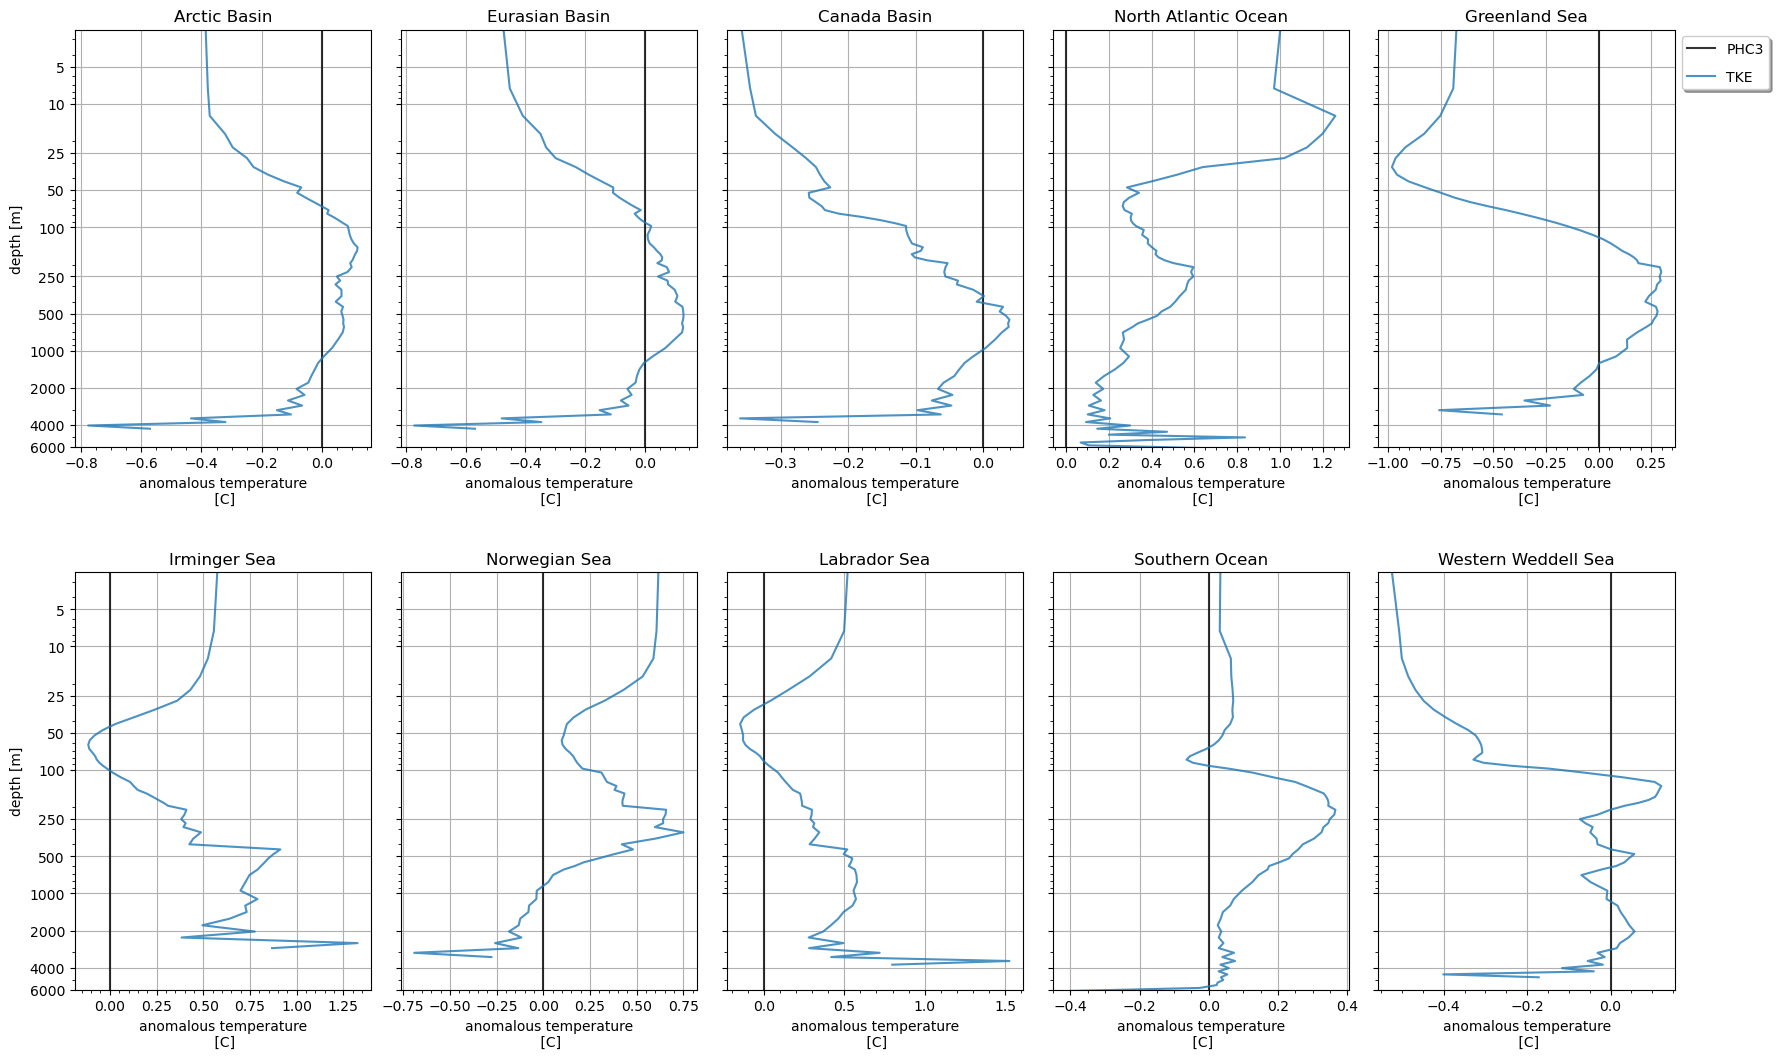

In [6]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = vname
slabel = data[sname].attrs['str_lsave']
if spath is not None: spath  = '{}/{}_{}_{}.png'.format(spath, which_mode, sname, slabel) 
nrow   = 2 
if save_fname is not None: spath = save_fname
fig, ax = tpv.plot_index_z(list_index,
                       list_labels,
                       box, figsize=[20,12], n_rc=[nrow,np.ceil(len(box)/nrow).astype(int)], # n_rc=[3,4],
                       linecolor_list= list_lcolor,
                       linestyle_list= list_lstyle,
                       linewidth     = list_lwidth,
                       do_save       = spath,
                      )  